# Pipeline de Dados Financeiros do Setor Elétrico

Este notebook implementa um pipeline para extração, transformação e análise das demonstrações financeiras padronizadas (DFPs) das empresas de geração elétrica no Brasil.

## 1. Configuração de Armazenamento

Funções para gerenciamento de caminhos de armazenamento nas diferentes camadas do data lake:

In [1]:
from datetime import datetime

def get_bronze_path(dataset):
    """Gera caminho para camada bronze"""
    return f"gs://pgera-bronze/{dataset}"

def get_silver_path(dataset):
    """Gera caminho para camada silver"""
    return f"gs://pgera-silver/{dataset}"

## 2. Ingestão de Dados Financeiros

### 2.1 Demonstrações Financeiras Padronizadas (DFPs)

Extração dos dados de demonstrações financeiras padronizadas das empresas de geração elétrica a partir dos dados disponibilizados pela CVM.

In [2]:
import os
import pandas as pd
import time
import zipfile
import requests
import io
from bs4 import BeautifulSoup

### 2.2 Acesso ao FTP da CVM

Funções para listar e baixar arquivos disponíveis no repositório FTP da Comissão de Valores Mobiliários (CVM):

In [3]:
def get_ftp_files(ftp_url):
    """Lista arquivos disponíveis no FTP da CVM"""
    response = requests.get(ftp_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    return [link.get_text() for link in soup.find_all('a') if 'DFP' in link.get_text().upper()]

def download_extract_zip(url, dest_folder):
    """Baixa e extrai arquivos ZIP"""
    os.makedirs(dest_folder, exist_ok=True)
    local_file = os.path.join(dest_folder, os.path.basename(url))
    
    # Download do arquivo
    with open(local_file, 'wb') as f:
        f.write(requests.get(url).content)
    
    # Extração de CSVs
    with zipfile.ZipFile(local_file) as z:
        return [z.extract(f, dest_folder) for f in z.namelist() if f.lower().endswith('.csv')]

### 2.3 Processamento de Demonstrações Financeiras

Funções para extração, transformação e carregamento (ETL) dos arquivos de DFPs até a camada silver:

In [4]:
def process_csv(file_path):
    """Processa um único arquivo CSV de DFP"""
    df = pd.read_csv(
        file_path, 
        delimiter=';', 
        encoding='latin1',
        dtype={'CNPJ_CIA': str, 'CD_CVM': str}
    )
    return df

def cleanup_files(folder, extensions=('.csv', '.zip')):
    """Remove arquivos temporários após processamento"""
    for file in os.listdir(folder):
        if file.lower().endswith(extensions):
            file_path = os.path.join(folder, file)
            try:
                os.remove(file_path)
            except OSError as e:
                print(f"Erro ao remover arquivo {file}: {e}")

def process_year(year, ftp_url):
    """Processa todos os arquivos DFP de um ano específico"""
    bronze_path = get_bronze_path("dfps")
    
    files = [f for f in get_ftp_files(ftp_url) if str(year) in f]
    
    if not files:
        print(f"Nenhum arquivo encontrado para o ano {year}")
        return False
    
    all_dfs = []
    
    for file_name in files:
        file_url = ftp_url + file_name
        print(f"Processando: {file_url}")
        
        # Download direto para memória
        response = requests.get(file_url)
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            csv_files = [f for f in z.namelist() if f.lower().endswith('.csv')]
            
            for csv_file in csv_files:
                with z.open(csv_file) as f:
                    df = pd.read_csv(
                        f,
                        delimiter=';',
                        encoding='latin1',
                        dtype={'CNPJ_CIA': str, 'CD_CVM': str}
                    )
                    if not df.empty:
                        all_dfs.append(df)
    
    if all_dfs:
        year_df = pd.concat(all_dfs, ignore_index=True)
        year_df.to_parquet(f"{bronze_path}/dfps_{year}.parquet", index=False)
        return True
    
    return False

def filter_companies_data(df, companies):
    """Filtra dados por empresa"""
    if companies is None or len(companies) == 0:
        return df
        
    mask = df['DENOM_CIA'].str.contains('|'.join(companies), case=False)
    filtered_df = df[mask]
    
    if filtered_df.empty:
        print("Aviso: Nenhuma empresa encontrada com os filtros fornecidos")
        return df
        
    return filtered_df

def enrich_dataframe(df):
    """Adiciona colunas derivadas ao DataFrame"""
    if df.empty:
        return df
    
    # Adiciona coluna de ano
    if 'DT_REFER' in df.columns:
        df['year'] = pd.to_datetime(df['DT_REFER']).dt.year
    
    # Extrai e normaliza grupo do DFP
    if 'GRUPO_DFP' not in df.columns and 'ARQUIVO' in df.columns:
        df['GRUPO_DFP'] = df['ARQUIVO'].str.extract(
            r'(BPA|BPP|DRE|DFC_MD|DFC_MI|DMPL|DRA|DVA)', expand=False)
        df.loc[df['GRUPO_DFP'].isin(['BPA', 'BPP']), 'GRUPO_DFP'] = 'BP'
    
    return df

def consolidate_years(years, companies):
    """Consolida dados de múltiplos anos"""
    silver_path = get_silver_path("dfps")
    
    all_dfs = []
    
    for year in years:
        df = pd.read_parquet(f"gs://pgera-bronze/dfps/dfps_{year}.parquet")
        print(f"Total de linhas lidas: {len(df)}")
        
        df = filter_companies_data(df, companies)
        print(f"Total de linhas após filtro: {len(df)}")
        
        df = enrich_dataframe(df)
        
        if '__index_level_0__' in df.columns:
            df = df.drop('__index_level_0__', axis=1)
        
        all_dfs.append(df)
    
    if all_dfs:
        common_columns = set.intersection(*[set(df.columns) for df in all_dfs])
        print(f"Colunas comuns encontradas: {len(common_columns)}")
        
        filtered_dfs = [df[list(common_columns)] for df in all_dfs]
        final_df = pd.concat(filtered_dfs, ignore_index=True)
        
        final_df.to_parquet(f"{silver_path}/dfps_consolidated.parquet", index=False)
        print(f"Dados consolidados salvos em: {silver_path}")

### 2.4 Processamento Completo de DFPs

Função principal que orquestra o pipeline de ingestão e processamento de DFPs para múltiplos anos:

In [5]:
def process_dfps(first_year=2010, last_year=2025, companies=None):
    """
    Processa demonstrações financeiras padronizadas (DFPs) para um intervalo de anos
    """
    start_time = time.time()
    ftp_url = 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/'
    
    # Configuração inicial
    companies = companies or [
        "Eletrobras", "Engie Brasil", "Neoenergia",
        "CPFL Energia", "Cemig", "Energisa", "Equatorial"
    ]
    
    # Processa cada ano
    processed_years = []
    for year in range(first_year, last_year + 1):
        print(f"\nProcessando ano {year}")
        if process_year(year, ftp_url):
            processed_years.append(year)
    
    if processed_years:
        print(f"\nConsolidando dados dos anos {processed_years}")
        consolidate_years(processed_years, companies)
        
        elapsed_time = time.time() - start_time
        print(f"Processamento concluído em {elapsed_time/60:.2f} minutos")
        return True
    
    
    return False


## 3. Exploração e Análise de Dados

### 3.1 Importações e Configuração do Ambiente

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, sum, expr

### 3.2 Execução do Pipeline de Processamento

Ingestão e processamento das DFPs para o período de análise:

In [7]:
process_dfps(first_year=2020, last_year=2023)


Processando ano 2020
Processando: https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/dfp_cia_aberta_2020.zip

Processando ano 2021
Processando: https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/dfp_cia_aberta_2021.zip

Processando ano 2022
Processando: https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/dfp_cia_aberta_2022.zip

Processando ano 2023
Processando: https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/dfp_cia_aberta_2023.zip

Consolidando dados dos anos [2020, 2021, 2022, 2023]
Total de linhas lidas: 1178536
Total de linhas após filtro: 37769
Total de linhas lidas: 1237654
Total de linhas após filtro: 37664
Total de linhas lidas: 1252084
Total de linhas após filtro: 37468
Total de linhas lidas: 1277883
Total de linhas após filtro: 37880
Colunas comuns encontradas: 31
Dados consolidados salvos em: gs://pgera-silver/dfps
Processamento concluído em 1.08 minutos


True

### 3.3 Configuração do Apache Spark

Inicialização da sessão Spark para processamento distribuído com integração ao Google Cloud Storage:

In [8]:
def init_spark_session():
    spark = SparkSession.builder \
        .appName("PGERA Silver") \
        .config("spark.sql.warehouse.dir", "gs://pgera-silver/spark-warehouse") \
        .config("hive.metastore.warehouse.dir", "gs://pgera-silver/hive-warehouse") \
        .config("spark.hadoop.fs.defaultFS", "gs://pgera-silver") \
        .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", 
               "/home/andrecamatta/.config/gcloud/application_default_credentials.json") \
        .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
        .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
        .enableHiveSupport() \
        .getOrCreate()

    # Forçar criação no GCS com LOCATION explícito
    spark.sql("""
        CREATE DATABASE IF NOT EXISTS pgera_silver 
        LOCATION 'gs://pgera-silver/databases/pgera_silver.db'
    """)
    
    return spark


### 3.4 Carregamento de Dados em Tabelas

Criação de tabelas externas no Hive a partir dos dados processados na camada silver:

In [9]:
def load_dfps_data(spark):
    # Apaga a tabela, se existir
    spark.sql("DROP TABLE IF EXISTS pgera_silver.dfps")
    # Cria uma tabela externa no Hive a partir do arquivo Parquet.

    ddl = """
        CREATE EXTERNAL TABLE IF NOT EXISTS pgera_silver.dfps (
        qt_acao_pref_tesouro DOUBLE,
        qt_acao_total_tesouro DOUBLE,
        coluna_df STRING,
        ds_conta STRING,
        vl_conta DOUBLE,
        cd_cvm STRING,
        id_doc DOUBLE,
        st_conta_fixa STRING,
        versao BIGINT,
        denom_cia STRING,
        tp_relat_aud STRING,
        cnpj_cia STRING,
        link_doc STRING,
        escala_moeda STRING,
        num_item_parecer_decl DOUBLE,
        qt_acao_total_cap_integr DOUBLE,
        dt_ini_exerc STRING,
        dt_receb STRING,
        qt_acao_ordin_cap_integr DOUBLE,
        txt_parecer_decl STRING,
        cd_conta STRING,
        qt_acao_ordin_tesouro DOUBLE,
        tp_parecer_decl STRING,
        categ_doc STRING,
        moeda STRING,
        dt_fim_exerc STRING,
        dt_refer STRING,
        `year` INT,
        ordem_exerc STRING,
        grupo_dfp STRING,
        qt_acao_pref_cap_integr DOUBLE
        )
        STORED AS PARQUET
        LOCATION 'gs://pgera-silver/dfps/';
        """

    # Executa o comando DDL
    spark.sql(ddl)


In [10]:
spark = init_spark_session()
# Cria o banco dados pgera caso não exista
dfps_df = load_dfps_data(spark)

25/04/05 14:39:24 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used
25/04/05 14:39:27 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


In [11]:
def create_horizontal_analysis_db(spark):
    # Apaga o banco para sobrescrever caso exista
    spark.sql("DROP DATABASE IF EXISTS horizontal_analysis CASCADE")
    
    # Cria o database especificando o local no GCS
    spark.sql("""
        CREATE DATABASE IF NOT EXISTS horizontal_analysis
        LOCATION 'gs://pgera-gold/horizontal_analysis'
    """)

def create_companies_table(spark):
    """
    Cria uma tabela na camada gold contendo empresas únicas e seus CNPJs.
    """
    # Apaga o banco se existir e recria
    spark.sql("""
        CREATE DATABASE IF NOT EXISTS horizontal_analysis
        LOCATION 'gs://pgera-gold/horizontal_analysis'
    """)
    
    # Cria a tabela com empresas únicas (usando DISTINCT para garantir que não haja duplicatas)
    ddl = """
    CREATE EXTERNAL TABLE horizontal_analysis.companies
    STORED AS PARQUET
    LOCATION 'gs://pgera-gold/horizontal_analysis/companies/'
    AS
    WITH unique_companies AS (
        SELECT DISTINCT
            cnpj_cia,
            FIRST_VALUE(denom_cia) OVER (
                PARTITION BY cnpj_cia 
                ORDER BY dt_refer DESC
            ) as nome_empresa,
            ROW_NUMBER() OVER (
                PARTITION BY cnpj_cia 
                ORDER BY dt_refer DESC
            ) as rn
        FROM pgera_silver.dfps
        WHERE cnpj_cia IS NOT NULL
    )
    SELECT 
        cnpj_cia as cnpj,
        nome_empresa
    FROM unique_companies
    WHERE rn = 1
    """
    
    # Executa o DDL
    spark.sql(ddl)
    
    print("Tabela de empresas criada com sucesso!")

# Cria o banco de dados
create_horizontal_analysis_db(spark)

# Cria a tabela
create_companies_table(spark)

# Verifica os dados
spark.sql("""
    SELECT *
    FROM horizontal_analysis.companies
    ORDER BY nome_empresa
""").show(truncate=False, n=100)

25/04/05 14:39:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Tabela de empresas criada com sucesso!


+------------------+---------------------------------------------------+
|cnpj              |nome_empresa                                       |
+------------------+---------------------------------------------------+
|06.981.180/0001-16|CEMIG DISTRIBUICAO S.A.                            |
|06.981.176/0001-58|CEMIG GERACAO E TRANSMISSAO S.A.                   |
|00.001.180/0001-26|CENTRAIS ELET BRAS S.A. - ELETROBRAS               |
|17.155.730/0001-64|CIA ENERGETICA DE MINAS GERAIS - CEMIG             |
|02.429.144/0001-93|CPFL ENERGIA S.A.                                  |
|08.439.659/0001-50|CPFL ENERGIAS RENOVÁVEIS S.A.                      |
|15.413.826/0001-50|ENERGISA MATO GROSSO DO SUL - DIST DE ENERGIA S.A. |
|03.467.321/0001-99|ENERGISA MATO GROSSO-DISTRIBUIDORA DE ENERGIA S/A  |
|19.527.639/0001-58|ENERGISA MINAS RIO - DISTRIBUIDORA DE ENERGIA S/A  |
|09.095.183/0001-40|ENERGISA PARAÍBA - DISTRIBUIDORA DE ENERGIA S/A    |
|00.864.214/0001-06|ENERGISA S.A.                  

In [12]:
def create_horizontal_analysis_table_al(spark):
    """
    Cria tabela de análise horizontal de ativos e passivos no pgera-gold com anos dinâmicos.
    """
    # Obtém os anos disponíveis nos dados
    years_df = spark.sql("""
        SELECT DISTINCT YEAR(dt_refer) as year 
        FROM pgera_silver.dfps 
        ORDER BY year
    """)
    years = [row.year for row in years_df.collect()]
    
    # Cria declarações CASE dinâmicas para os anos
    year_cases = [
        f"MAX(CASE WHEN ano = {year} THEN valor END) as `{year}`"
        for year in years
    ]
    years_sql = ",\n        ".join(year_cases)
    
    # Query para criar a tabela com análise horizontal dos BPs
    ddl = f"""
    CREATE EXTERNAL TABLE IF NOT EXISTS horizontal_analysis.assets_liabilities_analysis
    STORED AS PARQUET
    LOCATION 'gs://pgera-gold/horizontal_analysis/assets_liabilities_analysis/'
    AS
    WITH latest_versions AS (
        SELECT 
            cnpj_cia,
            denom_cia,
            dt_refer,
            MAX(versao) as max_versao
        FROM pgera_silver.dfps
        WHERE grupo_dfp LIKE '%DF Consolidado%'
        AND grupo_dfp LIKE '%Balanço Patrimonial%'
        GROUP BY cnpj_cia, denom_cia, dt_refer
    ),
    base_data AS (
        SELECT 
            d.cnpj_cia,
            d.denom_cia,
            d.ds_conta as conta,
            YEAR(d.dt_refer) as ano,
            d.vl_conta as valor
        FROM pgera_silver.dfps d
        INNER JOIN latest_versions lv 
            ON d.cnpj_cia = lv.cnpj_cia 
            AND d.dt_refer = lv.dt_refer 
            AND d.versao = lv.max_versao
        WHERE d.grupo_dfp LIKE '%DF Consolidado%'
        AND d.grupo_dfp LIKE '%Balanço Patrimonial%'
        AND d.st_conta_fixa = 'S'
        AND d.ds_conta IN (
            'Ativo Total',
            'Ativo Circulante',
            'Ativo Não Circulante',
            'Ativo Realizável a Longo Prazo',
            'Imobilizado',
            'Investimentos',
            'Intangível',
            'Passivo Total',
            'Passivo Circulante',
            'Passivo Não Circulante',
            'Patrimônio Líquido',
            'Patrimônio Líquido Consolidado'
        )
    )
    SELECT 
        cnpj_cia,
        denom_cia,
        conta,
        {years_sql}
    FROM base_data
    GROUP BY cnpj_cia, denom_cia, conta
    """
    
    # Executa o comando DDL
    spark.sql(ddl)
    
    print("Tabela de análise horizontal criada com sucesso!")

# Exemplo de uso
create_horizontal_analysis_table_al(spark)

# Para verificar os dados
spark.sql("""
    SELECT *
    FROM horizontal_analysis.assets_liabilities_analysis
    ORDER BY denom_cia, conta
""").show(truncate=False)

Tabela de análise horizontal criada com sucesso!
+------------------+------------------------------------+------------------------------+------------+------------+------------+------------+
|cnpj_cia          |denom_cia                           |conta                         |2020        |2021        |2022        |2023        |
+------------------+------------------------------------+------------------------------+------------+------------+------------+------------+
|06.981.176/0001-58|CEMIG GERACAO E TRANSMISSAO S.A.    |Ativo Circulante              |5104191.0   |5104191.0   |4997595.0   |4997595.0   |
|06.981.176/0001-58|CEMIG GERACAO E TRANSMISSAO S.A.    |Ativo Não Circulante          |1.5351674E7 |1.5617354E7 |1.5617354E7 |1.4991399E7 |
|06.981.176/0001-58|CEMIG GERACAO E TRANSMISSAO S.A.    |Ativo Realizável a Longo Prazo|9033708.0   |9033708.0   |8756724.0   |8305480.0   |
|06.981.176/0001-58|CEMIG GERACAO E TRANSMISSAO S.A.    |Ativo Total                   |2.0455865E7 |2.04

## 4. Análises Financeiras - Camada Gold

### 4.1 Criação de Análise Horizontal

Criação das tabelas para análise horizontal de balanços patrimoniais:

In [13]:
import matplotlib.pyplot as plt
def analyze_balance_sheet_company(cnpj, initial_year=2020, final_year=2021):
    """
    Realiza análise horizontal do Balanço Patrimonial de uma empresa usando dados da camada gold.
    """
    # Define ordem padrão das contas
    ordem_contas = [
        'Ativo Total',
        'Ativo Circulante',
        'Ativo Não Circulante',
        'Ativo Realizável a Longo Prazo',
        'Investimentos',
        'Imobilizado',
        'Intangível',
        'Passivo Total',
        'Passivo Circulante',
        'Passivo Não Circulante',
        'Patrimônio Líquido',
        'Patrimônio Líquido Consolidado'
    ]
    
    # Query com CASE statement corrigido
    query = f"""
    WITH ordered_accounts AS (
        SELECT 
            denom_cia,
            conta,
            `{initial_year}` as valor_inicial,
            `{final_year}` as valor_final,
            ROUND((`{final_year}` / `{initial_year}` - 1) * 100, 2) as var_percent,
            CASE conta
                WHEN 'Ativo Total' THEN 0
                WHEN 'Ativo Circulante' THEN 1
                WHEN 'Ativo Não Circulante' THEN 2
                WHEN 'Ativo Realizável a Longo Prazo' THEN 3
                WHEN 'Investimentos' THEN 4
                WHEN 'Imobilizado' THEN 5
                WHEN 'Intangível' THEN 6
                WHEN 'Passivo Total' THEN 7
                WHEN 'Passivo Circulante' THEN 8
                WHEN 'Passivo Não Circulante' THEN 9
                WHEN 'Patrimônio Líquido' THEN 10
                WHEN 'Patrimônio Líquido Consolidado' THEN 11
                ELSE 999
            END as ordem
        FROM horizontal_analysis.assets_liabilities_analysis
        WHERE cnpj_cia = '{cnpj}'
        AND `{initial_year}` IS NOT NULL 
        AND `{final_year}` IS NOT NULL
    )
    SELECT 
        denom_cia,
        conta,
        valor_inicial,
        valor_final,
        var_percent
    FROM ordered_accounts
    ORDER BY ordem
    """
    
    df_analise = spark.sql(query)
    
    # Converter para pandas para melhor visualização
    pd_analise = df_analise.toPandas()
    
    if pd_analise.empty:
        print(f"Nenhum dado encontrado para o CNPJ {cnpj} no período {initial_year}-{final_year}")
        return None
    
    # Configurar o nome da empresa
    empresa = pd_analise['denom_cia'].iloc[0]
    
    # Configurar o índice
    pd_analise.set_index('conta', inplace=True)
    pd_analise.drop('denom_cia', axis=1, inplace=True)
    
    # Mostrar resultados
    print(f"\nAnálise Horizontal do Balanço Patrimonial - {empresa}")
    print(f"Período: {initial_year} vs {final_year}")
    print("-" * 80)
    print(pd_analise)
    
    # Criar visualização
    plt.figure(figsize=(12, 6))
    plt.bar(pd_analise.index, pd_analise['var_percent'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Variação Percentual por Conta ({initial_year} vs {final_year})')
    plt.ylabel('Variação %')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return pd_analise



### 4.2 Visualização de Análises Financeiras

Função para gerar análises comparativas e visualizações de balanços patrimoniais por empresa:


Análise Horizontal do Balanço Patrimonial - EQUATORIAL S.A.
Período: 2021 vs 2022
--------------------------------------------------------------------------------
                                valor_inicial  valor_final  var_percent
conta                                                                  
Ativo Total                        61714300.0   90617397.0        46.83
Ativo Circulante                   21690029.0   21690029.0         0.00
Ativo Não Circulante               40024271.0   68928098.0        72.22
Ativo Realizável a Longo Prazo     23735540.0   34516422.0        45.42
Investimentos                        170594.0     170594.0         0.00
Imobilizado                          282061.0    5139309.0      1722.06
Intangível                         15836076.0   29245320.0        84.68
Passivo Total                      61714300.0   90617397.0        46.83
Passivo Circulante                 12989443.0   22099849.0        70.14
Passivo Não Circulante             34120385.

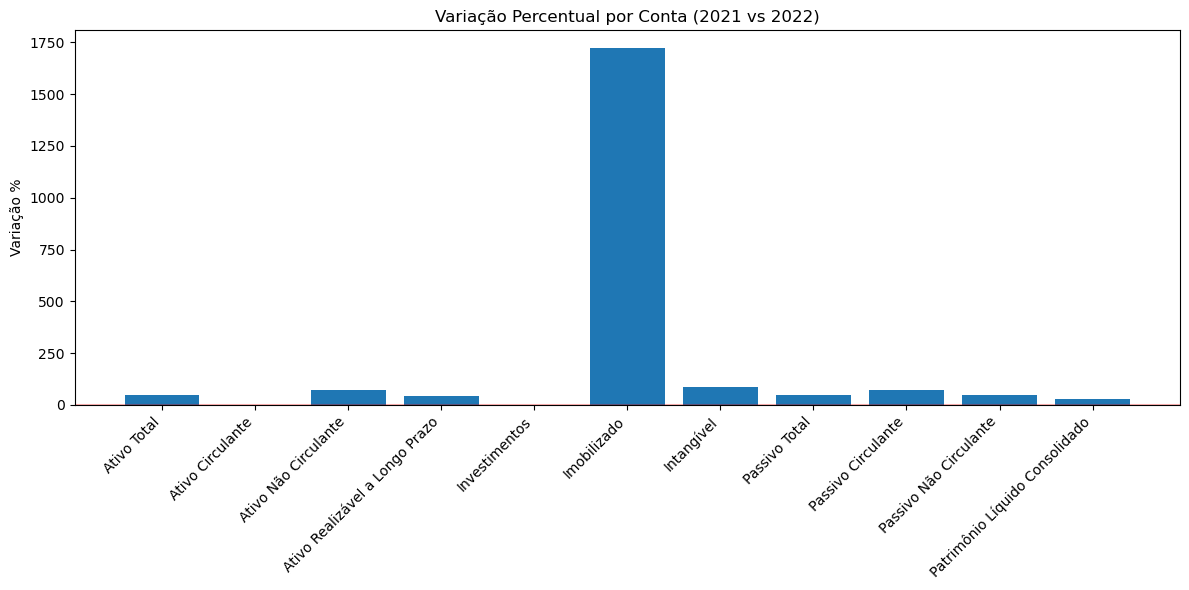

In [14]:
# Exemplo de uso
cnpj = "03.220.438/0001-73"
resultado = analyze_balance_sheet_company(cnpj, 2021, 2022)

## 5. Conclusão

Este notebook implementa um pipeline completo para análise de demonstrações financeiras do setor elétrico brasileiro:

1. **Ingestão**: Extração automática de DFPs da CVM
2. **Processamento**: Transformação dos dados nas camadas bronze e silver
3. **Análise**: Criação de métricas e visualizações na camada gold

As análises geradas permitem comparar o desempenho financeiro das principais empresas do setor elétrico ao longo do tempo.